In [182]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [183]:
def load_data(file_path):

    # Read file content
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize variables
    data, labels = [], []
    current_block, digit, block_count = [], 0, 0  # Track the current block, digit, and block count

    for line in lines:
        # Process non-blank lines
        if line.strip():
            # Extract and store the first 10 coefficients
            coefficients = list(map(float, line.split()))[:10]
            current_block.append(coefficients)
        else:
            # Handle the end of a block
            if current_block:
                # Calculate the average frame for the current block
                average_vector = np.mean(current_block, axis=0)
                data.append(average_vector)
                labels.append(digit)

                # Reset for the next block
                current_block = []
                block_count += 1

            # Move to the next digit after 220 blocks
            if block_count == 220:
                digit += 1
                block_count = 0

    # Ensure the final block is processed
    if current_block:
        average_vector = np.mean(current_block, axis=0)
        data.append(average_vector)
        labels.append(digit)

    return data, labels

In [184]:
def load_data_flatten(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []
    labels = []
    digit = 0
    current_block = []
    block_count = 0

    for line in lines:
        if line.strip():  # If the line is not blank
            features = list(map(float, line.split()))[:10]  # Take only first 10 coefficients
            current_block.append(features)
        else:  # End of a block
            if current_block:
                averaged_frame = np.mean(current_block, axis=0)
                data.append(averaged_frame)
                labels.extend([digit])  # Extend labels
                current_block = []
                block_count += 1

            if block_count == 660:  # 660 blocks per digit
                digit += 1
                block_count = 0

    # Check if the last block is processed
    if current_block:
        data.extend(current_block)
        labels.extend([digit] * len(current_block))

    return np.array(data), np.array(labels)

In [185]:
# Function to read the data
def read_mfcc_data(file_path):
    mfcc_blocks = []
    current_block = []
    with open(file_path, 'r') as file:
        # Iterates over each line in the file
        for line in file:
            
            # If the current block is finished, append it to the list of blocks
            if line.strip() == '':
                if current_block:
                    mfcc_blocks.append(current_block)
                    current_block = []
            else:
                # Convert each line to a list of floats (MFCC coefficients)
                frame = list(map(float, line.strip().split()))
                current_block.append(frame)
        # Append the last block if it ends without a blank line
        if current_block:
            mfcc_blocks.append(current_block)
    return mfcc_blocks

In [186]:
# Function to get the blocks for a desired digit
def get_digit_blocks(mfcc_blocks, digit):
    start = digit * 660
    end = start + 660
    
    return mfcc_blocks[start:end]

In [187]:
# Function to get the average vectors for each block for each digit
def get_average_vectors(mfcc_blocks):
    
    average_vectors = []
    for digit in range(10):
        # Gets the blocks for a certain digit
        digit_blocks = get_digit_blocks(mfcc_blocks, digit)

        average_blocks = [] # Stores the average vectors for the blocks for a certain digit
        # Gets the average vectors for the blocks
        for block in digit_blocks:
            # Gets the average vector for the individual block
            average = np.mean(block, axis=0)
            average_blocks.append(average)
        
        # Appends the average blocks to the list of average vectors
        average_vectors.append(average_blocks)
        
    return average_vectors

In [188]:
# Function to train the GMM model
def train_gmm_model(data, labels, num_components):
    gmm_models = []
    
    for digit in range(10):
        digit_data = data[np.array(labels) == digit]
        n_components = num_components[digit]
        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(digit_data)
        gmm_models.append(gmm)
        
    return gmm_models

In [189]:
# Function to calculate the log likelihood in a block
def get_block_likelihood(block, gmm):
    log_likelihoods = [gmm.score_samples([block])[0]]
    total_log_likelihood = np.sum(log_likelihoods)
    return total_log_likelihood

In [190]:
# Reads the data
file_path = './data/Train_Arabic_Digit.txt'
data, labels = load_data_flatten(file_path)

In [191]:
gmm_components = {0: 3, 1: 4, 2: 6, 3: 4, 4: 3, 5: 3, 6: 3, 7: 5, 8: 7, 9: 5}

In [192]:
# Train the GMM models
gmm_models = train_gmm_model(data, labels, gmm_components)

In [193]:
# Load the test data
test_file_path = './data/Test_Arabic_Digit.txt'
test_data, test_labels = load_data(test_file_path)

In [194]:
# Predict labels for each block in the test set
predicted_labels = []
for block in test_data:
    block_likelihoods = [get_block_likelihood(block, gmm) for gmm in gmm_models]
    predicted_digit = np.argmax(block_likelihoods)
    predicted_labels.append(predicted_digit)

In [195]:
# Calculate accuracy of the predictions
accuracy = np.mean(np.array(predicted_labels) == np.array(test_labels))
print(f'Overall Accuracy: {accuracy}')

Overall Accuracy: 0.6777272727272727


       Precision    Recall  F1-score
Digit                               
0       0.534202  0.745455  0.622391
1       0.704981  0.836364  0.765073
2       0.786802  0.704545  0.743405
3       0.769912  0.790909  0.780269
4       0.663158  0.859091  0.748515
5       0.724299  0.704545  0.714286
6       0.806897  0.531818  0.641096
7       0.520270  0.350000  0.418478
8       0.837662  0.586364  0.689840
9       0.558935  0.668182  0.608696


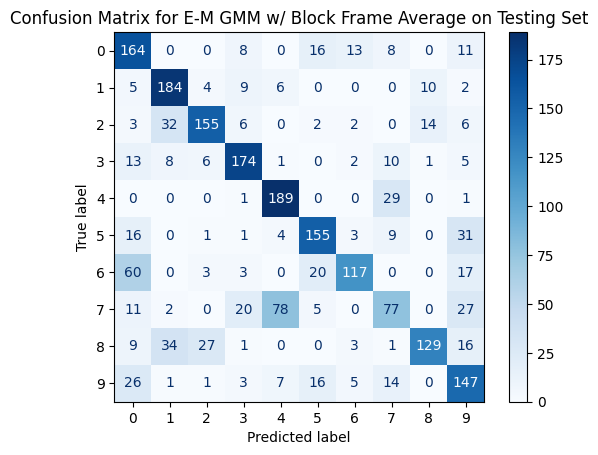

In [196]:
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, labels=np.arange(10))

# Create a DataFrame to hold the precision, recall, and F1-score for each digit
metrics_df = pd.DataFrame({
    'Digit': np.arange(10),
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
})

# Set the 'Digit' column as the index
metrics_df.set_index('Digit', inplace=True)

print(metrics_df)

all_digits = np.arange(10)
conf_matrix = confusion_matrix(test_labels, predicted_labels)
# Plotting the confusion matrix with annotations for all cells
# Plot using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(10))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for E-M GMM w/ Block Frame Average on Testing Set")
plt.savefig("confusionmatrixAvgGMM")
plt.show()